## This script is used for training auto encoder with custom generator in order to load large dataset


In [1]:
# imports

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from glob import glob
import numpy as np
import math
!pip install pydicom
import pydicom
import os
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Reshape, Dropout, UpSampling2D
from tensorflow.keras.callbacks import LambdaCallback
# print current working directory and tensorflow version
print()
print("--->current working direcotry:\n", os.getcwd())
print("--->tensorflow version:", tf.__version__)


--->current working direcotry:
 /home/ytx/myProjects/TensorflowV2/Dicom
--->tensorflow version: 2.1.0


In [2]:
 #hyperparameters
batch_size = 4

image_size = 512
EPOCHS = 30
img_width = img_height = image_size 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 128)     0     

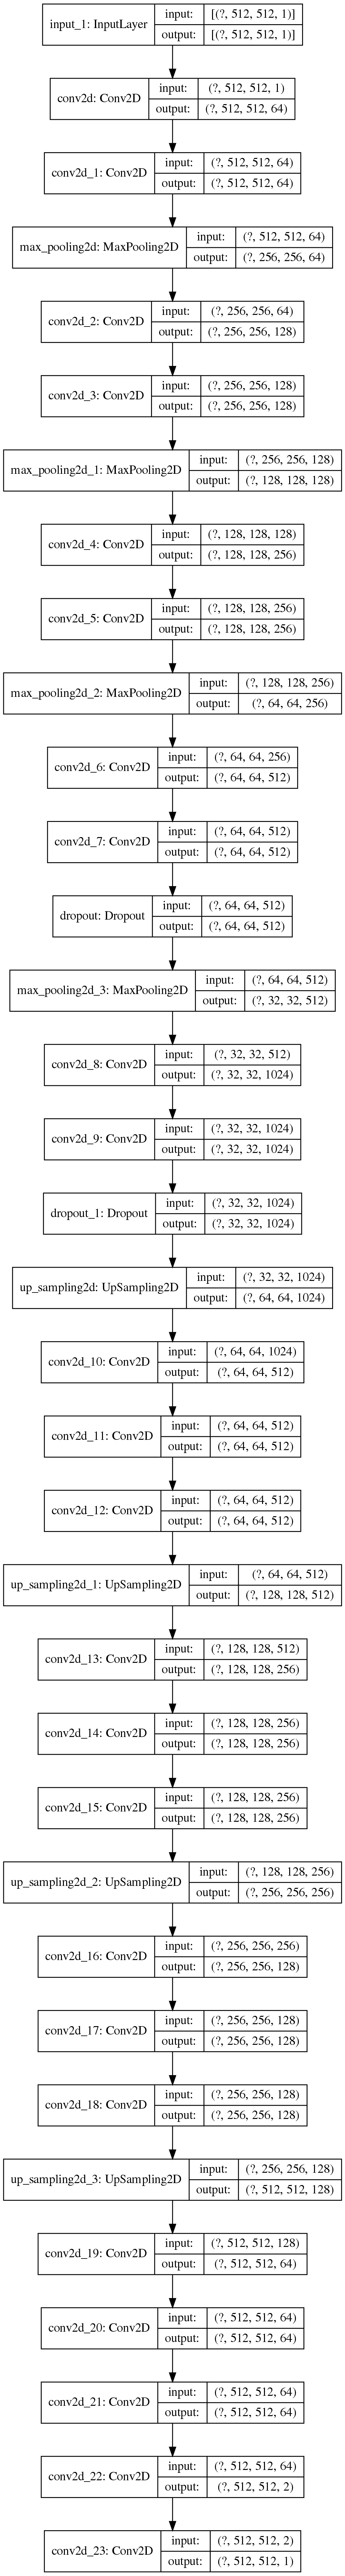

In [3]:
# create model
def U_NetV2():
    inputs = keras.layers.Input((image_size, image_size, 1))
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
#     merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
#     merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
#     merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
#     merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    outputs = Conv2D(1, 1, activation='linear')(conv9)
    model = keras.models.Model(inputs, outputs)
    return model
model =U_NetV2()
model.compile(loss='mse', optimizer='adam',
              metrics=['mse'])
model.summary()

keras.utils.plot_model(model, show_shapes=True, dpi=200, expand_nested=True)

In [4]:
# import cusstom generator class
from MyGenerators import DicomGenegeratorAutoTFio

In [ ]:
if __name__ == '__main__':
     # root dirs for dcms
    train_images_root = sorted(glob('/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/*'))
    val_images_root = sorted(glob('/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/val/*'))
    
   
    
    # create generator instances
    train_dcm_gen =  DicomGenegeratorAutoTFio(batch_size=batch_size, 
                                          train_or_test="train", 
                                          dims =(image_size, image_size),
                                          shuffle=False,
                                          train_images_root=train_images_root)
    val_dcm_gen =  DicomGenegeratorAutoTFio(batch_size=batch_size, 
                                          train_or_test="val", 
                                          dims =(image_size, image_size),
                                          shuffle=False,
                                          val_images_root=val_images_root)
    
    val_dcm_gen2_img =  DicomGenegeratorAutoTFio(batch_size=batch_size, 
                                          train_or_test="val", 
                                          dims =(image_size, image_size),
                                          shuffle=False,
                                          val_images_root=val_images_root)
    
    print(f'Found {len(train_dcm_gen.dcm_paths)} {train_dcm_gen.train_or_test} images ')
    print(f'Found {len(val_dcm_gen.dcm_paths)} {val_dcm_gen.train_or_test} images ')
    print(f'Found {train_dcm_gen.__len__()} training batches')
    print(f'Found {val_dcm_gen.__len__()} validation batches')
    
  
    print(f'Found {val_dcm_gen2_img.__len__()} validation batches for image prediction log')
    
    # define custome callbacks
    # some callbacks
# add the image call back
    import os
    from datetime import datetime
    logdir =  os.path.join("logs","image" + datetime.now().strftime("%Y%m%d-%H%M%S"))
    # Define the basic TensorBoard callback.
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    file_writer_img = tf.summary.create_file_writer(logdir + '/img')

#     @tf.function()
    def draw_input_output(epoch, logs):
        for idx, data in enumerate(val_dcm_gen2_img):
            print(idx)
            print("val_sample shape:", data[0].shape) # remember data generator now return (X, X)
            print("val_target shape:", data[1].shape)
#         print("min: {} max:{}".format(np.min(data), np.max(data)))
            output = model.predict(data[0]) # remember the data contains the both input and target (X, X)
            print("prediction shape:", output.shape)
            if idx >9:  # only take 10 samples for image logs
                    break
        with file_writer_img.as_default():
            tf.summary.image("test_output", tf.reshape(output,[-1, image_size , image_size , 1]), step=epoch)
    #         tf.summary.image("test_noisy_input", tf.reshape(x_test_noisy,[-1, image_size , image_size , 1]), step=epoch)
            tf.summary.image("test_input", tf.reshape(data[0],[-1, image_size , image_size , 1]), step=epoch)
    log_mg = keras.callbacks.LambdaCallback(on_epoch_end=draw_input_output)
    
    
    
    
    # fit model with built generator
#     H = model.fit(train_dcm_gen,
#                             validation_data=val_dcm_gen, 
#                             steps_per_epoch=6, 
#                             validation_steps=4,
#                             epochs=EPOCHS, 
#                             callbacks=[tensorboard_callback, log_mg],
#                             verbose=1)
    H = model.fit_generator(train_dcm_gen,
                            validation_data=val_dcm_gen, 
                            steps_per_epoch=train_dcm_gen.__len__(), 
                            validation_steps=val_dcm_gen.__len__(),
                            epochs=EPOCHS, 
                            callbacks=[tensorboard_callback, log_mg],
                            verbose=1)

root: /media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-006_000
one_root_paths: 1251

root: /media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-008_000
one_root_paths: 1182

root: /media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-012_000
one_root_paths: 665

root: /media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-015_001
one_root_paths: 1132

root: /media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-017_001
one_root_paths: 1226

root: /media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-019_001
one_root_paths: 1176

root: /media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-020_002
one_root_paths: 1251

root: /media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-021_001
one_root_paths: 1219

root: /media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-022_001
one_root_paths: 1251

root: /medi